# Fuse Data Scientist Work Sample

Welcome to Fuse Central High School, home of the _Fighting Cardinals!_
At this school, every student taking calculus has an opportunity to go on an exciting trip at the end of the school year to Cedar Point.

## How Students Qualify for the Trip

* Students take six tests throughout the semester
* The final grade is the average of their six test grades (rounded up to the nearest percent)
* Students who earn at least a B- (grade $\geq .80$) are permitted to attend to the class trip.

Last year after the first test, in order to help struggling students the school created an after school tutoring program.
Many students chose to enroll in this program to help them improve their grade enough to go on the trip.

## Your Task

The math department plans on offering the after school tutoring program again next year.
They have asked you to predict the impact of the program on student's grades.

1. Analyze the data and present any interestings findings you may discover.
2. Build a predictive model which takes as features the student's current test scores and predicts the impact on the student's final grade if they were to enroll in the tutoring program.
3. Evalute your model's performance with respect to a methodology of your choosing. Explain your reasoning in why you choose this method.

**Keep in mind that your model could be used throughout the school year, when students have not completed every test.
Being able to predict the student's final test grade when all 6 test grades are already known isn't a very difficult task since it is just the average.**


## The Data

The provided dataset is a CSV with columns

Column | Description
---------|-----------
`Student_ID` | The ID of the student
`Test_i_Grade` | The grade the student earned on Test `i` (`i = 1 to 6`)
`Final_Grade` | The average of the 6 test grades
`Tutoring` | Tells when the student enrolled in tutoring.

E.g. if `Tutoring` equals `Test_4` then this student enrolled in the tutoring program _before_ taking Test 4.
For students who did not enroll in tutoring, this column equals `Never`.

## Submision

You submission should consist of a ZIP archive with the following:

* A Jupyter notebook with the data analysis as well as code to train and evaluate your model.
* A requirements.txt file with any dependencies to run your code.
* One or more file(s) containing your model.
* Any other files, scripts, modules, or data needed to make your code work.

Your analysis for part 1 should be in the Jupyter notebook.
Be sure to include a cell at the end of your notebook with example code of how to load your model and use it on new data.


## Evaluation

In evaluating your submission, we will execute your notebook in a fresh Python virtual environment with the dependencies specified in the requitements.txt.
Additionally, we will evaluate your model on a testing dataset which has not been shared with you.

Your submission will be evaluated on the following criteria:
* Your notebook runs all the way through without exceptions or crashes.
* The code is clear and easy to understand.
* Good use of comments and markdown sections explaining what is going on.
* The analysis is compelling.
* Supporting plots are explained.
* There are no problems loading your model and evaluating on the testing set.
* Your model perdicts relatively well on the testing data.

# Modules

In [ ]:
!python3 --version

Python 3.8.5


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

# Data manipulation
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split

# Data Visualization
from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
np.set_printoptions(precision=3, suppress=True)


# Statistical models and tests
from statsmodels.stats.stattools import jarque_bera
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import probplot
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error
)

In [ ]:
# Directories
DATA_DIR = './data/'
MODEL_DIR = './models/'

# Custom functions

In [ ]:
def custom_corr_plot(df, title, columns):
    ''' Custom Correlation plot

        Pairwise Pearson's correlation matrix
        Strength of correlation:
            .00-.19 “very weak”
            .20-.39 “weak”
            .40-.59 “moderate”
            .60-.79 “strong”
            .80-1.0 “very strong”
        
        # Arguments:
            df: dataframe.
            title: title of chart.
            columns: columns to calculate correlation matrix.

        # Returns:
            matplotlib object.
    '''
    # Pairwise Pearson's correlation matrix
    df_corr = df[columns].corr(method='pearson').round(3)
    # Mask for Correlation Matrix plot
    mask = np.zeros_like(df_corr)
    mask[np.triu_indices_from(mask)] = True
    # Plot
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12.5, 5.5))
    ax = sns.heatmap(df_corr,
                     cmap=sns.diverging_palette(20, 200, sep=20, as_cmap=True),
                     center=0, vmin=-1, vmax=1, mask=mask, linewidths=.01, linecolor='#cbcbcb',
                     annot=True)
    plt.xticks(rotation=45)
    # Title
    plt.gcf().text(0.09, 1, title, fontsize=20, weight='bold', alpha=.8)
    plt.gcf().text(0.09, .94, "Pearson's correlation", fontsize=15, alpha=.8)
    plt.tight_layout(pad=3)
    return plt

def custom_normality_test(x):
    ''' Function to test for normality using Jarque-Bera test

        # Arguments:
            x: data to test for normality.

        # Returns:
            Dict with statistics.
    '''
    norm_test_labels = ['jb_stat', 'jb_pvalue', 'skew', 'kurtosis']
    result = dict(zip(
        norm_test_labels,
        np.round(jarque_bera(x), 6)
    ))
    return result

def custom_resid_tests(model, title=''):
    ''' Residual tests: Normality, Independence, Homoscedasticity
        
        # Arguments:
            model: model instance

        # Returns:
            Print Test Results
    '''
    print(title)
    print('Formula: %s' % model.model.formula)
    print('\nResidual Tests\n---')
    # Jarque-Bera test: Normality in residuals.
    print('Normality: Jarque-Bera test')
    norm_test_labels = ['jb_stat', 'jb_pvalue', 'skew', 'kurtosis']
    print(dict(zip(norm_test_labels, np.round(jarque_bera(model.wresid), 5))))
    print('---')
    # Ljung-Box test of autocorrelation in residuals.
    print('Independence: Ljung-Box test')
    print(diagnostic.acorr_ljungbox(x=model.resid, lags=1, return_df=True).to_dict('records')[0])
    print('---')
    # Bresch-Pagan test of residuals Homoscedasticity
    het_test_labels = ['LM_stat', 'LM_pvalue', 'F_stat', 'F_pvalue']
    print('Homoscedasticity: Breusch-Pagan test')
    print(dict(zip(het_test_labels, np.round(diagnostic.het_breuschpagan(model.resid, model.model.exog), 5))))


def custom_resid_fit_plot(model, layout=(0, 0), loc=(0, 0)):
    ''' Custom Standardized Residuals vs Fitted plot.

        # Arguments:
            model: model instance
            layout: matplotlib layout of figure
            loc: matplotlib loc of chart in layout

        # Returns:
            ax: matplotlib Axis
    '''
    residuals = model.get_influence().resid_studentized_internal
    fitted = model.fittedvalues
    smoothed = lowess(residuals, fitted.values, frac=.7)
    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax.scatter(fitted, residuals, facecolors='#666666', alpha=.5)
    ax.plot(smoothed[:,0],smoothed[:,1], color = 'r', lw=2)
    ax.grid(axis='both', alpha=.4)
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Standardized Residuals vs. Fitted', fontdict={'fontsize': 16})
    ax.axhline(y=0, color='#666666', ls='--', lw=1)
    return ax

def custom_resid_qqplot(model, layout=(0, 0), loc=(0, 0)):
    ''' Custom Normal Quantile-Quantile plot

        # Arguments:
            model: model instance
            layout: matplotlib layout of figure
            loc: matplotlib loc of chart in layout
            
        # Returns:
            ax: matplotlib Axis
    '''
    student_resid = sorted(model.get_influence().resid_studentized_internal)
    theoretical_quantiles = probplot(x=student_resid, dist='norm', fit=False)[0]
    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax.scatter(x=theoretical_quantiles, y=student_resid, facecolor='#666666', alpha=.5)
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_title('Normal Q-Q', fontdict={'fontsize': 16})
    ax.plot(
        [np.min([theoretical_quantiles, student_resid]), np.max([theoretical_quantiles, student_resid])],
        [np.min([theoretical_quantiles, student_resid]), np.max([theoretical_quantiles, student_resid])],
        'r--', lw=1
    )
    ax.grid(axis='both', alpha=.4)
    return ax

def custom_resid_hist(model, layout=(0, 0), loc=(0, 0)):
    ''' Custom function to create Residual Histogram plot

        # Arguments:
            model: model instance
            layout: matplotlib layout of figure
            loc: matplotlib loc of chart in layout
            
        # Returns:
            ax: matplotlib Axis
    '''
    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax = sns.distplot(model.get_influence().resid_studentized_internal,
                      bins=8, hist=True, kde=True, norm_hist=True, 
                      hist_kws={'edgecolor':'#ffffff', 'alpha': .8, 'color': '#666666', 'label': 'hist'},
                      kde_kws={'linewidth': 2, 'color': '#0f4c81', 'label': 'kde'})
    ax.grid(axis='both', alpha=.4)
    ax.set_xlabel('Standardized Residuals')
    ax.set_title('Standardized Residuals Histogram', fontdict={'fontsize': 16})
    ax.legend(fontsize='small')
    return ax

def custom_residual_plots(model, figsize=(18, 8)):
    ''' Custom Residuals Diagnostic plots

        # Arguments:
            model: model instance
            figsize: matplotlib figure of figure

        # Returns
            fig: matplotlib Figure
            ax: matplotlib Axis
    '''
    fig, ax = plt.subplots(figsize=figsize)
    fig_layout = (1, 3)
    ax1 = custom_resid_fit_plot(model=model, layout=fig_layout, loc=(0, 0))
    ax2 = custom_resid_qqplot(model=model, layout=fig_layout, loc=(0, 1))
    ax3 = custom_resid_hist(model=model, layout=fig_layout, loc=(0, 2))
    return fig, ax


# Data

## Reading Data

Using pandas to read the dataset and load it into a dataframe.


In [ ]:
# Read data
DATA_PATH = os.path.join(DATA_DIR, 'grades.csv')
grades = pd.read_csv(DATA_PATH)

In [ ]:
# See dataset
grades

,Student_ID,Test_1_Grade,Test_2_Grade,Test_3_Grade,Test_4_Grade,Test_5_Grade,Test_6_Grade,Final_Grade,Tutoring
0,0,0.76,0.83,0.85,0.85,0.94,0.59,0.81,Test_2
1,1,0.83,0.75,0.80,0.80,0.67,0.72,0.77,Test_2
2,2,0.64,0.59,0.84,0.77,0.83,0.69,0.73,Test_3
3,3,0.83,0.80,0.90,0.70,0.80,0.82,0.81,Test_5
4,4,0.68,0.89,0.90,0.90,0.95,0.98,0.89,Test_2
...,...,...,...,...,...,...,...,...,...
495,495,0.78,0.89,0.81,0.81,0.90,0.96,0.86,Never
496,496,0.97,0.80,0.64,0.75,0.91,0.72,0.80,Never
497,497,0.53,0.50,0.74,0.81,0.83,0.63,0.68,Test_3
498,498,0.71,0.71,0.81,0.88,0.84,0.86,0.81,Test_3


## Checking for Missing Values.

In [ ]:
# Consice summary of the dataframe
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Student_ID    500 non-null    int64  
 1   Test_1_Grade  500 non-null    float64
 2   Test_2_Grade  500 non-null    float64
 3   Test_3_Grade  500 non-null    float64
 4   Test_4_Grade  500 non-null    float64
 5   Test_5_Grade  500 non-null    float64
 6   Test_6_Grade  500 non-null    float64
 7   Final_Grade   500 non-null    float64
 8   Tutoring      500 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 35.3+ KB


In [ ]:
# Check NA values
grades.isnull().sum().to_dict()

{'Student_ID': 0,
 'Test_1_Grade': 0,
 'Test_2_Grade': 0,
 'Test_3_Grade': 0,
 'Test_4_Grade': 0,
 'Test_5_Grade': 0,
 'Test_6_Grade': 0,
 'Final_Grade': 0,
 'Tutoring': 0}

There is no missing value in the dataset. No need for an imputation technique.

## Checking for Duplicate Stutent IDs

In [ ]:
# Check number of unique IDs
n_unique_ids = len(set(grades['Student_ID'].values))
print(f"Total of unique Student IDs: {n_unique_ids:,}")

Total of unique Student IDs: 500


No duplicate Student IDs as expected.

## Checking Tutoring Categories

In [ ]:
unique_tutoring = sorted(list(set(grades['Tutoring'].values)))
unique_tutoring

['Never', 'Test_2', 'Test_3', 'Test_4', 'Test_5', 'Test_6']

Tutoring categories as expected: 

`['Never', 'Test_2', 'Test_3', 'Test_4', 'Test_5', 'Test_6']`

## Checking Final Grades

In [ ]:
# Tests
test_grades_columns = ['Test_1_Grade', 'Test_2_Grade', 'Test_3_Grade',
                       'Test_4_Grade', 'Test_5_Grade', 'Test_6_Grade']

# Calculated Final Grade
calculated_final_grade = np.ceil(grades[test_grades_columns].mean(axis=1)*100)/100

# Assert with data Final_Grade
print(f"Final_Grade == Average Test Grades: "
      f"{sum(calculated_final_grade == grades['Final_Grade']) == len(grades)}")

Final_Grade == Average Test Grades: True


Final Grade values as expected.

# Part 1 - Exploratory Data Analysis 

This section presents an Exploratory Data Analysis - EDA, and it will analyze variables individually and the relationship with other variables to understand the dataset and provide insights to tasks to be completed.

In [ ]:
# See first 5 rows of dataset
grades.head()

,Student_ID,Test_1_Grade,Test_2_Grade,Test_3_Grade,Test_4_Grade,Test_5_Grade,Test_6_Grade,Final_Grade,Tutoring
0,0,0.76,0.83,0.85,0.85,0.94,0.59,0.81,Test_2
1,1,0.83,0.75,0.80,0.80,0.67,0.72,0.77,Test_2
2,2,0.64,0.59,0.84,0.77,0.83,0.69,0.73,Test_3
3,3,0.83,0.80,0.90,0.70,0.80,0.82,0.81,Test_5
4,4,0.68,0.89,0.90,0.90,0.95,0.98,0.89,Test_2


## Reshaped dataset

First, reshaping the dataset to better visualize using ggplot.

In [ ]:
# Grades variables
grades_columns = ['Test_1_Grade', 'Test_2_Grade', 'Test_3_Grade',
                  'Test_4_Grade', 'Test_5_Grade', 'Test_6_Grade',
                  'Final_Grade']

# Reshape dataset
df_grades = (
    grades
    .melt(id_vars=['Student_ID', 'Tutoring'],
          value_vars=grades_columns,
          var_name='Test',
          value_name='Grade')
    .sort_values(['Student_ID', 'Test'])
    .reset_index(drop=True)
)

# Checking reshaping
print(f"Reshaping correct: {df_grades.groupby('Student_ID').size().count()==500}")

Reshaping correct: True


Creating the variable to identify if the student enrolled in the tutoring program before taking the test.



In [ ]:
# Creating variable
# `Enrolled Tutoring` : if student enrolled in the tutoring program before taking test

def get_enrolled_tutoring(test, tutoring):
    ''' Function to verify if Student enrolled in the tutoring program before taking test.

        # Arguments:
            test: a string with the test id.
            tutoring: a string with the tutoring id.
        
        # Retunrs:
            A string saying Yes or No.
    '''
    # Regex to get number from string
    re_get_number = re.compile(r'\d')

    # Getting 
    if tutoring == 'Never':
        enrolled_tutoring = 'No'
    else:
        if test == 'Final_Grade':
            enrolled_tutoring = 'Yes'
        else:
            tutoring = np.int(re_get_number.findall(tutoring)[0])
            test = np.int(re_get_number.findall(test)[0])
            if tutoring <= test:
                enrolled_tutoring = 'Yes'
            else:
                enrolled_tutoring = 'No'
    return enrolled_tutoring

# Creating
df_grades['Enrolled Tutoring'] = (
    df_grades
    .apply(lambda row: get_enrolled_tutoring(row['Test'], row['Tutoring']),
           axis=1))

Creating the variable for the number of tests made when students were enrolled in the tutoring program.

In this study, we will consider the number of tests in the Tutoring Program how many tests the student had done tests after enrolled in the tutoring program.

Also, considering that once enrolled, the student participated in all tutoring activities.

In [ ]:
# Creating variable for number of tests enrolled in tutoring program

# `Number Tests Enrolled`:
#   - if Enrolled before 'Test_2' then n_tests_enrolled: 5 -> {2, 3, 4, 5, 6}
#   - if Enrolled before 'Test_3' then n_tests_enrolled: 4 -> {3, 4, 5, 6}
#   - if Enrolled before 'Test_4' then n_tests_enrolled: 3 -> {4, 5, 6}
#   - if Enrolled before 'Test_5' then n_tests_enrolled: 2 -> {5, 6}
#   - if Enrolled before 'Test_6' then n_tests_enrolled: 1 -> {6}
#   - if Enrolled is     'Never'  then n_tests_enrolled: 0 -> {}

n_tests_enrolled = {'Test_2': '5',
                    'Test_3': '4',
                    'Test_4': '3',
                    'Test_5': '2',
                    'Test_6': '1',
                    'Never': '0'}

# Creating
df_grades['Number Tests Enrolled'] = df_grades['Tutoring'].map(n_tests_enrolled)

Checking if reshaping dataset and variables were created successfully.

In [ ]:
# Checking `Enrolled Tutoring`

def check_enrolled_tutoring(df, tutoring, expected):
    ''' Function to check if `Enrolled Tutoring` variable is correct.
        
        # Arguments:
            df: the data frame
            tutoring: when the student enrolled in tutoring.
            expected: number of expected No.

        # Return:
            A string.
    '''
    return 'SUCCESS' if len(df[['Tutoring', 'Enrolled Tutoring', 'Test']]
                            .query(f'Tutoring == "{tutoring}"')
                            .drop_duplicates()
                            .query('`Enrolled Tutoring` == "No"')
                            .index) == expected else 'FAIL'

print(f"Testing `Enrolled Tutoring` for Test_2: "
      f"{check_enrolled_tutoring(df_grades, 'Test_2', 1)}")
print(f"Testing `Enrolled Tutoring` for Test_3: "
      f"{check_enrolled_tutoring(df_grades, 'Test_3', 2)}")
print(f"Testing `Enrolled Tutoring` for Test_4: "
      f"{check_enrolled_tutoring(df_grades, 'Test_4', 3)}")
print(f"Testing `Enrolled Tutoring` for Test_5: "
      f"{check_enrolled_tutoring(df_grades, 'Test_5', 4)}")
print(f"Testing `Enrolled Tutoring` for Test_6: "
      f"{check_enrolled_tutoring(df_grades, 'Test_6', 5)}")
print(f"Testing `Enrolled Tutoring` for Never: "
      f"{check_enrolled_tutoring(df_grades, 'Never', 7)}")


# Checking `Number Tests Enrolled`

def check_number_tests_enrolled(df, tutoring, expected):
    ''' Function to check if `Number Tests Enrolled` is correct.
        
        # Arguments:
            df: the data frame
            tutoring: when the student enrolled in tutoring.
            expected: number of expected `Number Tests Enrolled`.

        # Return:
            A string.
    '''
    return 'SUCCESS' if (df[['Tutoring', 'Number Tests Enrolled']]
                         .drop_duplicates()
                         .query(f'Tutoring == "{tutoring}"')['Number Tests Enrolled'].values[0]) == expected else 'FAIL'

print(f"Testing `Number Tests Enrolled` for Test_2: "
      f"{check_number_tests_enrolled(df_grades, 'Test_2', '5')}")
print(f"Testing `Number Tests Enrolled` for Test_3: "
      f"{check_number_tests_enrolled(df_grades, 'Test_3', '4')}")
print(f"Testing `Number Tests Enrolled` for Test_4: "
      f"{check_number_tests_enrolled(df_grades, 'Test_4', '3')}")
print(f"Testing `Number Tests Enrolled` for Test_5: "
      f"{check_number_tests_enrolled(df_grades, 'Test_5', '2')}")
print(f"Testing `Number Tests Enrolled` for Test_6: "
      f"{check_number_tests_enrolled(df_grades, 'Test_6', '1')}")
print(f"Testing `Number Tests Enrolled` for Never: "
      f"{check_number_tests_enrolled(df_grades, 'Never', '0')}")

Testing `Enrolled Tutoring` for Test_2: SUCCESS
Testing `Enrolled Tutoring` for Test_3: SUCCESS
Testing `Enrolled Tutoring` for Test_4: SUCCESS
Testing `Enrolled Tutoring` for Test_5: SUCCESS
Testing `Enrolled Tutoring` for Test_6: SUCCESS
Testing `Enrolled Tutoring` for Never: SUCCESS
Testing `Number Tests Enrolled` for Test_2: SUCCESS
Testing `Number Tests Enrolled` for Test_3: SUCCESS
Testing `Number Tests Enrolled` for Test_4: SUCCESS
Testing `Number Tests Enrolled` for Test_5: SUCCESS
Testing `Number Tests Enrolled` for Test_6: SUCCESS
Testing `Number Tests Enrolled` for Never: SUCCESS


Reshaping dataset and variables were created successfully.

In [ ]:
# First 5 rows of reshaped dataframe
df_grades.head()

,Student_ID,Tutoring,Test,Grade,Enrolled Tutoring,Number Tests Enrolled
0,0,Test_2,Final_Grade,0.81,Yes,5
1,0,Test_2,Test_1_Grade,0.76,No,5
2,0,Test_2,Test_2_Grade,0.83,Yes,5
3,0,Test_2,Test_3_Grade,0.85,Yes,5
4,0,Test_2,Test_4_Grade,0.85,Yes,5


## Distribution of Students that reach the goal to attend to the class trip

Only 47.4% (237) of the Students reached the goal to attend the class trip.


In [ ]:
# Describe only Grades Variables
grades.describe(exclude=[np.int64, np.object])

,Test_1_Grade,Test_2_Grade,Test_3_Grade,Test_4_Grade,Test_5_Grade,Test_6_Grade,Final_Grade
count,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.714720,0.75334,0.772140,0.779700,0.786200,0.787900,0.770100
std,0.137382,0.13866,0.130798,0.125149,0.124035,0.111241,0.102058
min,0.320000,0.37000,0.260000,0.300000,0.270000,0.310000,0.410000
25%,0.630000,0.65000,0.700000,0.710000,0.720000,0.730000,0.720000
50%,0.715000,0.78000,0.790000,0.810000,0.800000,0.800000,0.790000
75%,0.810000,0.86000,0.860000,0.870000,0.870000,0.870000,0.830000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.970000


In [ ]:
n_attend_trip = np.sum(grades['Final_Grade'] >= .8)
n_students = len(grades)

print(f"Percetange of Students permitted to attend to the class trip: "
      f"{n_attend_trip/n_students*100:.1f}% ({n_attend_trip})")

Percetange of Students permitted to attend to the class trip: 47.4% (237)


Next, it will analyze the Tutoring program's impact.

## Distribution of Students Enrolled in tutoring program

The distribution follows:

*   32.8% (164) of the Students enrolled in tutoring program before taking Test 2

*   26.4% (132) of the Students 'Never' enrolled in the tutoring program.

*   20.8% (104) of the Students enrolled in tutoring program before taking Test 3

* Only 4.6% (23) of the students enrolled in the tutoring program before the last Test.


63.6% of the Students that 'Never' enrolled had a Final Grade greater than .8, reaching the goal to attend the class trip.

25% of the Students that 'Never' enrolled had Final Grade greater than .9, also reaching the goal to attend the class trip.

Only 28.6% (10) of the Students that enrolled before Test 5 reach the trip goal.

49.4% (81) of the Students that enrolled after Test 1 reach the trip goal. And this percentual decrease to next enrolled periods, except before Test 6, where increase (30.4%) compared with the previous period (28.6%).

Indicating that more time in the tutoring program, more likely to have better grades and reach the goal.

In [ ]:
# Table 1
print("* FG: Final Grade")
table_1 = pd.concat(
    [grades['Tutoring'].value_counts(),
     grades['Tutoring'].value_counts(normalize=True).mul(100).round(2),
     grades.groupby('Tutoring')['Final_Grade'].mean().round(3),
     grades.groupby('Tutoring')['Final_Grade'].median(),
     grades.groupby('Tutoring')['Final_Grade'].quantile(.75),
     grades.groupby('Tutoring')['Final_Grade'].agg([('>=.8', lambda x: sum(x>=.8))])['>=.8'],
     grades.groupby('Tutoring')['Final_Grade'].agg([('%>=.8', lambda x: sum(x>=.8)/len(x))])['%>=.8'].mul(100).round(1),
     ],
     axis=1, names='',
     keys=('Count', 'Percentage', 'FG* (Mean)', 'FG* (Median)',
         'FG* (75%)', 'Count >=.8', 'Percentage >=.8'),
).reindex(['Test_2', 'Test_3', 'Test_4', 'Test_5', 'Test_6', 'Never'])
table_1

* FG: Final Grade


,Count,Percentage,FG* (Mean),FG* (Median),FG* (75%),Count >=.8,Percentage >=.8
Test_2,164,32.8,0.788,0.79,0.82,81.0,49.4
Test_3,104,20.8,0.778,0.78,0.82,41.0,39.4
Test_4,42,8.4,0.754,0.75,0.81,14.0,33.3
Test_5,35,7.0,0.726,0.72,0.80,10.0,28.6
Test_6,23,4.6,0.696,0.68,0.80,7.0,30.4
Never,132,26.4,0.771,0.84,0.90,84.0,63.6


## Boxplot of Grades per Test and Enrolled Tutoring

The boxplot of Grades indicates a difference between the distribution of Student's Final Grade that who 'Never' enrolled and who enrolled in some period.

50% of the Students that 'Never' enrolled have a Final Grade greater than 75% of the students that enrolled.

But de 50% of the Students that 'Never' enrolled have Final Grade more disperse than Students that enrolled.

Also, for each test, students that enrolled before the test have better performance on average than students that not enrolled, except for the last test. Indicating again that the tutoring program increases the grades.

We will perform a test to verify if there is a statistically significant difference between students that 'Never' enrolled and enrolled. In this study, we are only observing the grades without control by other variables.

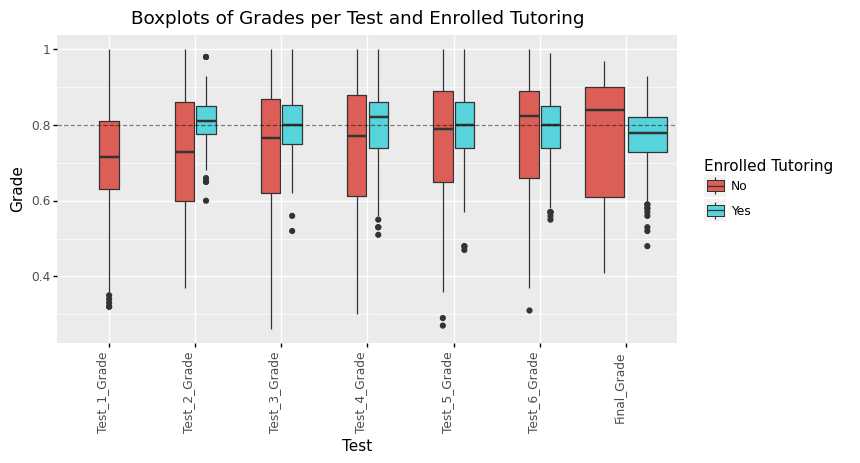

<ggplot: (8730717915745)>

In [ ]:
# Boxplot of Grades per Test and Enrolled Tutoring
custom_theme = theme(axis_text_x=element_text(angle=90, hjust=1), # flip_xlabels
                     figure_size=(8, 4)) # Resize figure
(
    ggplot(data=df_grades)
    + aes(y='Grade', x='Test', fill='Enrolled Tutoring')
    + geom_boxplot(width=.5, varwidth=False)
    + geom_hline(yintercept=.8, linetype='dashed', alpha=.5)
    + custom_theme
    + scale_x_discrete(limits=grades_columns)
    + xlab('Test')
    + ylab('Grade')
    + ggtitle('Boxplots of Grades per Test and Enrolled Tutoring')
)

## Histogram of Grades per Test and Enrolled Tutoring

Before performing the statistical test, we will observe the normality of the data to choose the appropriate test.

Histograms indicate the data is not normally distributed.

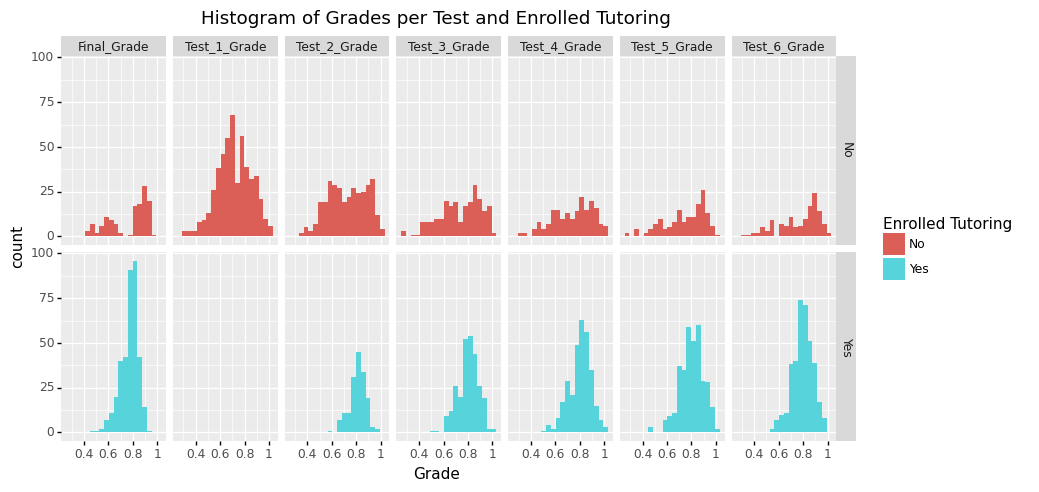

<ggplot: (8730715731264)>

In [ ]:
# Histogram of Grades per Test and Enrolled Tutoring
custom_theme = theme(figure_size=(10, 5)) # Resize figure
(
    ggplot(data=df_grades)
    + aes(x='Grade', fill='Enrolled Tutoring')
    + geom_histogram(bins=20)
    + facet_grid('Enrolled Tutoring~Test')
    + custom_theme
    + ggtitle('Histogram of Grades per Test and Enrolled Tutoring') 
)

## Normality Test for Grades per Test and Enrolled Tutoring

Performing the normality test using the Jarque-Bera Test.

In [ ]:
# Test for Normality using Jarque-Bera Test - Final Grade
print("Final Grade:", custom_normality_test(df_grades.query('Test == "Final_Grade"')['Grade']))
print("Final Grade - Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Final_Grade"')['Grade']))
print("Final Grade - Not Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "No" and Test == "Final_Grade"')['Grade']))

Final Grade: {'jb_stat': 96.73767, 'jb_pvalue': 0.0, 'skew': -0.950179, 'kurtosis': 4.015896}
Final Grade - Enrolled: {'jb_stat': 62.891503, 'jb_pvalue': 0.0, 'skew': -0.838374, 'kurtosis': 4.135841}
Final Grade - Not Enrolled: {'jb_stat': 16.574164, 'jb_pvalue': 0.000252, 'skew': -0.743648, 'kurtosis': 2.104772}


In [ ]:
# Test for Normality using Jarque-Bera Test - Test Grades Enrolled
print("Test_2_Grade - Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_2_Grade"')['Grade']))
print("Test_3_Grade - Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_3_Grade"')['Grade']))
print("Test_4_Grade - Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_4_Grade"')['Grade']))
print("Test_5_Grade - Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_5_Grade"')['Grade']))
print("Test_6_Grade - Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_6_Grade"')['Grade']))

Test_2_Grade - Enrolled: {'jb_stat': 3.188677, 'jb_pvalue': 0.203043, 'skew': -0.303569, 'kurtosis': 3.313082}
Test_3_Grade - Enrolled: {'jb_stat': 3.337419, 'jb_pvalue': 0.18849, 'skew': -0.266783, 'kurtosis': 3.119081}
Test_4_Grade - Enrolled: {'jb_stat': 12.448429, 'jb_pvalue': 0.001981, 'skew': -0.463931, 'kurtosis': 3.320657}
Test_5_Grade - Enrolled: {'jb_stat': 12.145, 'jb_pvalue': 0.002305, 'skew': -0.401066, 'kurtosis': 3.448837}
Test_6_Grade - Enrolled: {'jb_stat': 5.555578, 'jb_pvalue': 0.062176, 'skew': -0.297074, 'kurtosis': 3.096483}


In [ ]:
# Test for Normality using Jarque-Bera Test - Test Grades Not Enrolled
print("Test_2_Grade - Not Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_2_Grade"')['Grade']))
print("Test_3_Grade - Not Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_3_Grade"')['Grade']))
print("Test_4_Grade - Not Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_4_Grade"')['Grade']))
print("Test_5_Grade - Not Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_5_Grade"')['Grade']))
print("Test_6_Grade - Not Enrolled:", custom_normality_test(df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_6_Grade"')['Grade']))

Test_2_Grade - Not Enrolled: {'jb_stat': 13.627207, 'jb_pvalue': 0.001099, 'skew': -0.155893, 'kurtosis': 2.063965}
Test_3_Grade - Not Enrolled: {'jb_stat': 11.799475, 'jb_pvalue': 0.00274, 'skew': -0.499677, 'kurtosis': 2.528908}
Test_4_Grade - Not Enrolled: {'jb_stat': 9.745509, 'jb_pvalue': 0.007652, 'skew': -0.478419, 'kurtosis': 2.438332}
Test_5_Grade - Not Enrolled: {'jb_stat': 15.438111, 'jb_pvalue': 0.000444, 'skew': -0.762368, 'kurtosis': 2.743878}
Test_6_Grade - Not Enrolled: {'jb_stat': 14.662565, 'jb_pvalue': 0.000655, 'skew': -0.798307, 'kurtosis': 2.658324}


Final Grades (Enrolled and Not Enrolled) are not normally distributed (Jarque-Berra test: p-value < 1%).

Test Grades Not Enrolled are not normally distributed (Jarque-Berra test: p-value < 1%).

Based on these results, we will use the Mann-Whitney U test, a nonparametric test, to verify if there is a statistically significant difference between Enrolled and Not Enrolled.

## Difference of Final Grades (Enrolled x Not Enrolled)

There is a significant difference in the median of Test Grade between students who were enrolled and were not Enrolled in the tutoring program (Mann-Whitney U test: p-value < 1%).

Except for Grades of Test 5 (Mann-Whitney U test: p-value > 1%, but close 1%) and Test 6 (Mann-Whitney U test: p-value > 30%)

Indicating that students in the last tests keep the same average.

In [ ]:
def custom_sig_test(pvalue):
    return '*' if pvalue < .01 else ''

def print_mannwhitneyu_result(result, name):
    print(f"{name:<13}: "
        f"stat={result.statistic:,.0f} - "
        f"pvalue={result.pvalue:.4f} "
        f"{custom_sig_test(result.pvalue)}")

# Final Grade
r_final_grade = stats.mannwhitneyu(
    df_grades.query('`Enrolled Tutoring` == "No" and Test == "Final_Grade"')['Grade'],
    df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Final_Grade"')['Grade']
)
print_mannwhitneyu_result(r_final_grade, 'Final Grade')

# Test_2_Grade
r_test_2_grade = stats.mannwhitneyu(
    df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_2_Grade"')['Grade'],
    df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_2_Grade"')['Grade']
)
print_mannwhitneyu_result(r_test_2_grade, 'Test_2_Grade')


# Test_3_Grade
r_test_3_grade = stats.mannwhitneyu(
    df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_3_Grade"')['Grade'],
    df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_3_Grade"')['Grade']
)
print_mannwhitneyu_result(r_test_3_grade, 'Test_3_Grade')

# Test_4_Grade
r_test_4_grade = stats.mannwhitneyu(
    df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_4_Grade"')['Grade'],
    df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_4_Grade"')['Grade']
)
print_mannwhitneyu_result(r_test_4_grade, 'Test_4_Grade')

# Test_5_Grade
r_test_5_grade = stats.mannwhitneyu(
    df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_5_Grade"')['Grade'],
    df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_5_Grade"')['Grade']
)
print_mannwhitneyu_result(r_test_5_grade, 'Test_5_Grade')

# Test_6_Grade
r_test_6_grade = stats.mannwhitneyu(
    df_grades.query('`Enrolled Tutoring` == "No" and Test == "Test_6_Grade"')['Grade'],
    df_grades.query('`Enrolled Tutoring` == "Yes" and Test == "Test_6_Grade"')['Grade']
)
print_mannwhitneyu_result(r_test_6_grade, 'Test_6_Grade')

print('\n* There is significant difference (alpha=1%)')

Final Grade  : stat=19,020 - pvalue=0.0001 *
Test_2_Grade : stat=19,275 - pvalue=0.0000 *
Test_3_Grade : stat=25,267 - pvalue=0.0002 *
Test_4_Grade : stat=24,456 - pvalue=0.0007 *
Test_5_Grade : stat=23,570 - pvalue=0.0170 
Test_6_Grade : stat=23,712 - pvalue=0.3431 

* There is significant difference (alpha=1%)


## Boxplot of Final Grades per Number of Tests Enrolled in Tutoring Program

Another interesting analysis is the Final Grades per Number of Tests Enrolled in Tutoring, in this one we may see if there is a significant difference between them.

The Boxplot shows a difference between Final Grades and the number of tests enrolled. Indicating it is more likely to have a bigger score when more tests when enrolled in tutoring.

Boxplots indicating Final Grades when not Enrolled or Enrolled in 5 tests are not normally. We will perform a normality test to check it.

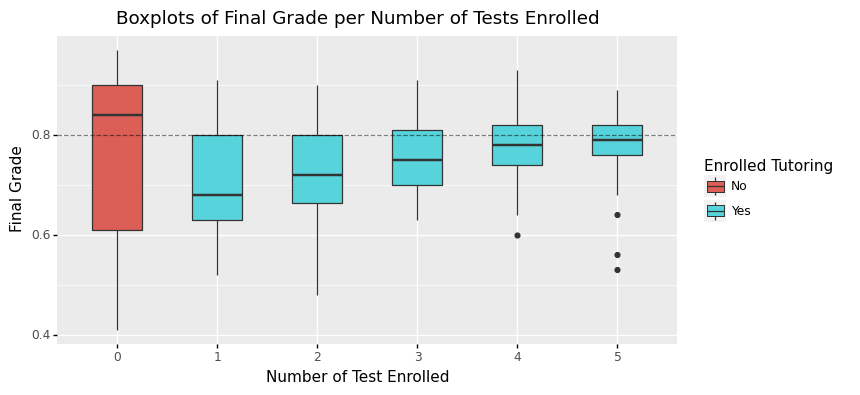

<ggplot: (8730715279430)>

In [ ]:
custom_theme = theme(figure_size=(8, 4)) # Resize figure
(
    ggplot(data=df_grades.query('Test == "Final_Grade"'))
    + aes(y='Grade', x='Number Tests Enrolled', fill='Enrolled Tutoring')
    + geom_boxplot(width=.5, varwidth=False)
    + geom_hline(yintercept=.8, linetype='dashed', alpha=.5)
    + custom_theme
    # + scale_x_discrete(limits=grades_columns)
    + xlab('Number of Test Enrolled')
    + ylab('Final Grade')
    + ggtitle('Boxplots of Final Grade per Number of Tests Enrolled')
)

## Normality Test for Final Grades per Number of Tests Enrolled in Tutoring Program

Performing the normality test using the Jarque-Bera Test.

In [ ]:
# Test for Normality using Jarque-Bera Test - Final Grades per Number of Tests Enrolled
print("Final Grade - Number Tests Enrolled=0: ", custom_normality_test(df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "0"')['Grade']))
print("Final Grade - Number Tests Enrolled=1: ", custom_normality_test(df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "1"')['Grade']))
print("Final Grade - Number Tests Enrolled=2: ", custom_normality_test(df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "2"')['Grade']))
print("Final Grade - Number Tests Enrolled=3: ", custom_normality_test(df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "3"')['Grade']))
print("Final Grade - Number Tests Enrolled=4: ", custom_normality_test(df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "4"')['Grade']))
print("Final Grade - Number Tests Enrolled=5: ", custom_normality_test(df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "5"')['Grade']))

Final Grade - Number Tests Enrolled=0:  {'jb_stat': 16.574164, 'jb_pvalue': 0.000252, 'skew': -0.743648, 'kurtosis': 2.104772}
Final Grade - Number Tests Enrolled=1:  {'jb_stat': 0.803955, 'jb_pvalue': 0.668996, 'skew': 0.263824, 'kurtosis': 2.251337}
Final Grade - Number Tests Enrolled=2:  {'jb_stat': 0.097871, 'jb_pvalue': 0.952242, 'skew': -0.06164, 'kurtosis': 2.772155}
Final Grade - Number Tests Enrolled=3:  {'jb_stat': 1.375961, 'jb_pvalue': 0.50259, 'skew': 0.169662, 'kurtosis': 2.180779}
Final Grade - Number Tests Enrolled=4:  {'jb_stat': 2.167839, 'jb_pvalue': 0.338267, 'skew': -0.288832, 'kurtosis': 3.408135}
Final Grade - Number Tests Enrolled=5:  {'jb_stat': 133.259352, 'jb_pvalue': 0.0, 'skew': -1.232082, 'kurtosis': 6.664597}


Final Grades are normally distributed when students are enrolled in 1, 2, 3, and 4 tests (Jarque-Berra test: p-value > 1%).

Final Grades are not normally distributed when students are not Enrolled or when Enrolled in 5 tests (Jarque-Berra test: p-value < 1%).

Based on these results, we will use the Mann-Whitney U test, a nonparametric test, to verify if there is a statistically significant difference between them.

## Difference of Final Grades per Number of Tests in Tutoring Program

We do not need to verify all pair-wise differences. Here, we will verify the difference when students are not enrolled with when enrolled. And the sequence of enrolled, i.e., enrolled 1 test against enrolled 2 tests, enrolled 2 tests against enrolled 3 tests, and so on.

In [ ]:
# when enrolled x not enrolled
r_enrolled_1_x_not = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "0"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "1"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_1_x_not, 'Enrolled 1 x Not Enrolled')

r_enrolled_2_x_not = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "0"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "2"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_2_x_not, 'Enrolled 2 x Not Enrolled')

r_enrolled_3_x_not = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "0"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "3"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_3_x_not, 'Enrolled 3 x Not Enrolled')

r_enrolled_4_x_not = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "0"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "4"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_4_x_not, 'Enrolled 4 x Not Enrolled')

r_enrolled_5_x_not = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "0"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "5"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_5_x_not, 'Enrolled 5 x Not Enrolled')

r_enrolled_1_x_2 = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "1"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "2"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_1_x_2, 'Enrolled 1 x 2')

r_enrolled_2_x_3 = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "2"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "3"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_2_x_3, 'Enrolled 2 x 3')

r_enrolled_3_x_4 = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "3"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "4"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_3_x_4, 'Enrolled 3 x 4')

r_enrolled_4_x_5 = stats.mannwhitneyu(
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "4"')['Grade'],
    df_grades.query('Test == "Final_Grade" and `Number Tests Enrolled` == "5"')['Grade']
)
print_mannwhitneyu_result(r_enrolled_4_x_5, 'Enrolled 4 x 5')

print('\n* There is significant difference (alpha=1%)')

Enrolled 1 x Not Enrolled: stat=967 - pvalue=0.0028 *
Enrolled 2 x Not Enrolled: stat=1,690 - pvalue=0.0074 *
Enrolled 3 x Not Enrolled: stat=2,140 - pvalue=0.0131 
Enrolled 4 x Not Enrolled: stat=5,485 - pvalue=0.0040 *
Enrolled 5 x Not Enrolled: stat=8,738 - pvalue=0.0022 *
Enrolled 1 x 2: stat=329 - pvalue=0.1226 
Enrolled 2 x 3: stat=588 - pvalue=0.0667 
Enrolled 3 x 4: stat=1,700 - pvalue=0.0181 
Enrolled 4 x 5: stat=7,493 - pvalue=0.0468 

* There is significant difference (alpha=1%)


There is a significant difference in the median of Final Grades between students that were enrolled in 1, 2, 4, and 5 tests and the Final Grades of students who were not enrolled in the tutoring program (Mann-Whitney U test: p-value < 1%).

Except for when enrolled in 3 tests (Mann-Whitney U test: p-value > 1%, but close 1%)

Comparing between the pairs of students that were enrolled (1x2, 2x3, 3x4, 4x5), there is no significant difference in the median of Final Grades between them (Mann-Whitney U test: p-value > 1%, but for 3x4 is close 1%)

## Correlation Matrix of Grades

As expected, Test Grades are strongly correlated with Final Grade (final grade is an average of test grades).

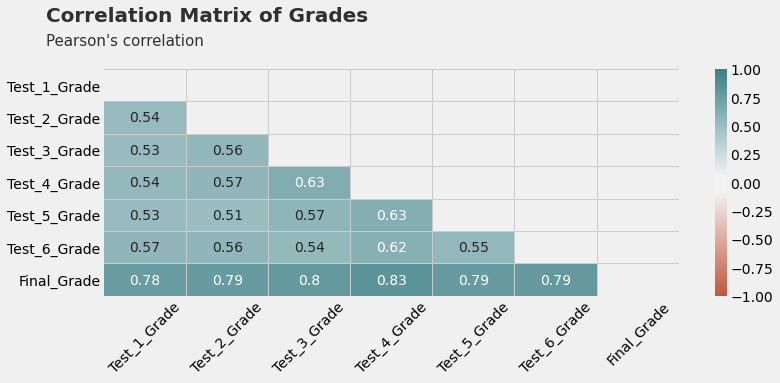

In [ ]:
# Correlation Matrix of Grades
_ = custom_corr_plot(grades, columns=grades_columns, title='Correlation Matrix of Grades')

## Number of Tests Enrolled in the Tutoring Program

In this study, we will consider the number of tests in the Tutoring Program how many tests the student had done tests after enrolled in the tutoring program.

Also, considering that once enrolled in the tutoring program, the student participated in all tutoring activities.

In [ ]:
# Creating variable for number of tests enrolled in tutoring program

# `Number Tests Enrolled`:
#   - if Enrolled before 'Test_2' then n_tests_enrolled: 5 -> {2, 3, 4, 5, 6}
#   - if Enrolled before 'Test_3' then n_tests_enrolled: 4 -> {3, 4, 5, 6}
#   - if Enrolled before 'Test_4' then n_tests_enrolled: 3 -> {4, 5, 6}
#   - if Enrolled before 'Test_5' then n_tests_enrolled: 2 -> {5, 6}
#   - if Enrolled before 'Test_6' then n_tests_enrolled: 1 -> {6}
#   - if Enrolled is     'Never'  then n_tests_enrolled: 0 -> {}

# Creating variable to calculate Correlation Matrix
n_tests_enrolled = {'Test_2': 5,
                    'Test_3': 4,
                    'Test_4': 3,
                    'Test_5': 2,
                    'Test_6': 1,
                    'Never': 0}

grades['n_Tests_Enrolled'] = grades['Tutoring'].map(n_tests_enrolled)

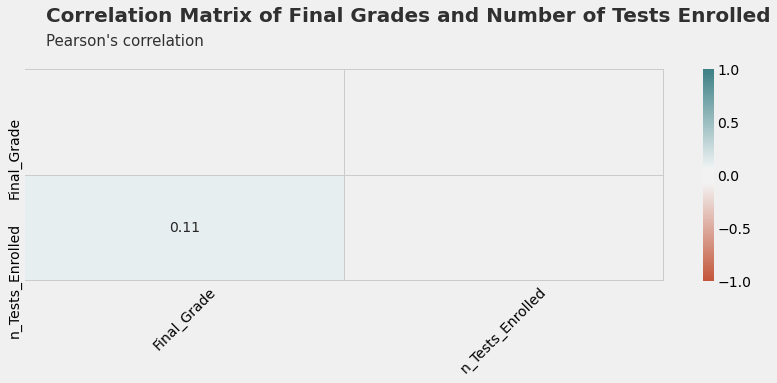

In [ ]:
# Correlation Matrix of Final Grade and Number of Tests Enrolled
_ = custom_corr_plot(grades,
                     columns=['Final_Grade', 'n_Tests_Enrolled'],
                     title='Correlation Matrix of Final Grades and Number of Tests Enrolled')

# Part 2 - Predictive Model

## The Model

Based on EDA, we will build a predictive model using Final Score as the response.

As features:
- the average of student's current test scores without tutoring
- how many tests the students will be enrolled in the tutoring program. if they chose to enroll it.

Assuming that:

-  Once enrolled in the tutoring program, the student participated in all future tutoring activities.

- And, the tests are structured in a way that evaluates a progression in the student's learning.

We will use the Multiple Linear Regression Model.

where

$\mathbf {y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}},\quad
{\displaystyle X={\begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix}}={\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix}},\quad}
{\displaystyle {\boldsymbol {\beta }}={\begin{pmatrix}\beta _{0}\\\beta _{1}\\\beta _{2}\\\vdots \\\beta _{p}\end{pmatrix}},\quad {\boldsymbol {\varepsilon }}={\begin{pmatrix}\varepsilon _{1}\\\varepsilon _{2}\\\vdots \\\varepsilon _{n}\end{pmatrix}}.}$


- $\mathbf {y}$: vector of observed values.
- $X$: matrix of explanatory variables.
- $\boldsymbol \beta$: parameter vector;
- $\boldsymbol \varepsilon$: vector of errors (residuals).


This model with the features selected and response variable can be used throughout the school year, even when students have not completed all tests, and must be able to analyze the impact of the tutoring program on the student's final grade.

Because we are selecting the progression of learning by the average student's current test scores without tutoring.

And if they choose to enroll in the tutoring program, the model will be able to verify how many tests under the tutoring program can impact on Final Grade.


## Building our train dataset

We will create two variables:

- partial_score: the average of tests before enroll in the tutoring program.
- n_tutoring: number of tests it will be enrolled in the tutoring program.

And we will split the dataset in two: train (80%) and test (20%)

In [ ]:
encoder = {
    'Test_2': {'scores': ['Test_1_Grade'],
               'n_tutoring': 5},
    'Test_3': {'scores': ['Test_1_Grade', 'Test_2_Grade'],
               'n_tutoring': 4},
    'Test_4': {'scores': ['Test_1_Grade', 'Test_2_Grade', 'Test_3_Grade',],
               'n_tutoring': 3},
    'Test_5': {'scores': ['Test_1_Grade', 'Test_2_Grade', 'Test_3_Grade', 'Test_4_Grade'],
               'n_tutoring': 4},
    'Test_6': {'scores': ['Test_1_Grade', 'Test_2_Grade', 'Test_3_Grade', 'Test_4_Grade', 'Test_5_Grade'],
               'n_tutoring': 1},
    'Never': {'scores': ['Test_1_Grade', 'Test_2_Grade', 'Test_3_Grade', 'Test_4_Grade', 'Test_5_Grade', 'Test_6_Grade'],
              'n_tutoring': 0}
}

def get_n_tutoring_from_pd_dataframe(df):
    return df.apply(lambda row: encoder[row['Tutoring']]['n_tutoring'], axis=1)

def get_partial_score_from_pd_dataframe(df):
    return df.apply(lambda row: np.mean(row[encoder[row['Tutoring']]['scores']]), axis=1)

In [ ]:
# Get dataset for training
dataset = grades.copy()
dataset['n_tutoring'] = get_n_tutoring_from_pd_dataframe(dataset)
dataset['partial_score'] = get_partial_score_from_pd_dataframe(dataset)

# Filtering and rename
dataset = (dataset
           .filter(items=['partial_score', 'n_tutoring', 'Final_Grade'])
           .rename(columns={'Final_Grade': 'final_grade'}))

In [ ]:
# View dataset
dataset

,partial_score,n_tutoring,final_grade
0,0.760000,5,0.81
1,0.830000,5,0.77
2,0.615000,4,0.73
3,0.807500,4,0.81
4,0.680000,5,0.89
...,...,...,...
495,0.858333,0,0.86
496,0.798333,0,0.80
497,0.515000,4,0.68
498,0.710000,4,0.81


In [ ]:
# Split dataset into train and test
train, test = train_test_split(dataset, test_size=0.2, random_state=22)

## Training the model

In [ ]:
# OLS
model = smf.ols('final_grade ~ partial_score + n_tutoring', data=train).fit()
print(model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.792     
Dependent Variable: final_grade      AIC:                -1327.6327
Date:               2020-11-25 14:29 BIC:                -1315.6583
No. Observations:   400              Log-Likelihood:     666.82    
Df Model:           2                F-statistic:        759.3     
Df Residuals:       397              Prob (F-statistic): 2.08e-136 
R-squared:          0.793            Scale:              0.0021029 
--------------------------------------------------------------------
                   Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
Intercept          0.1687    0.0157  10.7635  0.0000  0.1379  0.1995
partial_score      0.7789    0.0202  38.5731  0.0000  0.7392  0.8186
n_tutoring         0.0140    0.0012  12.0987  0.0000  0.0117  0.0163
------------------------------------------------------------

Results for the Model:

Variables coeficientes are significant:

*   Intercept is significant (p-value << 1%, CI95% [.1379, .1995])
*   partial_score is significant (p-value << 1%, CI95% [ 0.74,  0.82])
*   n_tutoring is significant (p-value << 1%, CI95% [ .0118, .0163])

A good Adj. R-squared=0.792.

The model has a positive correlation between each feature and the response variable.

Also, It indicates that when increases one unit the number of tests made when the students are enrolled in the tutoring program, the mean of Final Grade also tends to increase 1.4 percentage point.

So, answering the Math Department, in average, the tutoring program has a positive impact on a student's final grades.

# Part 3 - Evaluation

## Residual Analysis



For the evaluation, we will analyze the model residuals:

*   Approximately Normally distributed;
*   Be independent of one another over time
*   Heteroskedasticity

In [ ]:
# Residuals test
custom_resid_tests(model, title='Model')

Model
Formula: final_grade ~ partial_score + n_tutoring

Residual Tests
---
Normality: Jarque-Bera test
{'jb_stat': 9.21902, 'jb_pvalue': 0.00996, 'skew': 0.28598, 'kurtosis': 3.4754}
---
Independence: Ljung-Box test
{'lb_stat': 0.07986404526050034, 'lb_pvalue': 0.7774817369767428}
---
Homoscedasticity: Breusch-Pagan test
{'LM_stat': 34.23666, 'LM_pvalue': 0.0, 'F_stat': 18.58026, 'F_pvalue': 0.0}


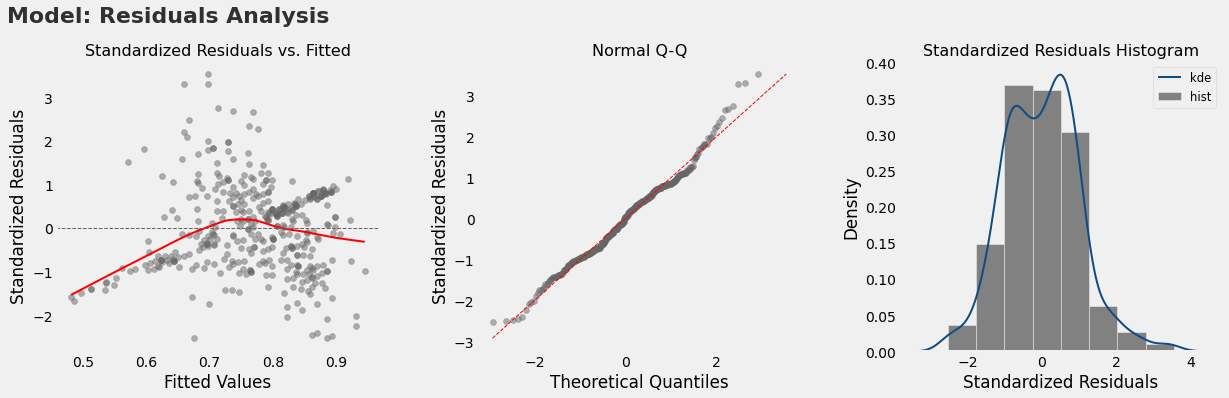

In [ ]:
# Residuals plot
custom_residual_plots(model, figsize=(18, 6))
# Title
plt.gcf().text(0.03, .95, 'Model: Residuals Analysis', fontsize=22, weight='bold', alpha=.8)
plt.tight_layout(pad=3)

Residuals are normally distributed (Jarque-Bera test: p-value << 1%).

They are independent of one another over time (Ljung-Box test: p-value > 1%).

Residuals variance are not Homoscedasticity (Breusch-Pagan test: p-value << 1%). But the dispersion does not appear dramatically heterogenous, and the average of the residuals is constant for predicted values greater than .7. Even with this violation of model assumptions, we will keep this as a baseline model to predict the impact on the student's final grade.

## Test Prediction

We assessed the performance using the root-mean-square error (RMSE) and mean-absolute error (MAE) between the actual grades and the predicted ones.


In [ ]:
# Prediction, RMSE and MAE
pred = model.get_prediction(exog=test)
rmse_stat = np.sqrt(mean_squared_error(test['final_grade'], pred.predicted_mean))
mae_stat = mean_absolute_error(test['final_grade'], pred.predicted_mean)
print(f'RMSE: Test={rmse_stat:,.2f}')
print(f' MAE: Test={mae_stat:,.2f}')

RMSE: Test=0.05
 MAE: Test=0.04


## Saving the model

In [ ]:
# Saving baseline model
MODEL_PATH = os.path.join(MODEL_DIR, 'baseline_regression_linear.pickle')
model.save(MODEL_PATH)

## Loading the Saved model

In [ ]:
from statsmodels.iolib.smpickle import load_pickle

model_loaded = load_pickle(MODEL_PATH)

In [ ]:
# Checking results
print(model_loaded.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.792     
Dependent Variable: final_grade      AIC:                -1327.6327
Date:               2020-11-25 14:29 BIC:                -1315.6583
No. Observations:   400              Log-Likelihood:     666.82    
Df Model:           2                F-statistic:        759.3     
Df Residuals:       397              Prob (F-statistic): 2.08e-136 
R-squared:          0.793            Scale:              0.0021029 
--------------------------------------------------------------------
                   Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
Intercept          0.1687    0.0157  10.7635  0.0000  0.1379  0.1995
partial_score      0.7789    0.0202  38.5731  0.0000  0.7392  0.8186
n_tutoring         0.0140    0.0012  12.0987  0.0000  0.0117  0.0163
------------------------------------------------------------

In [ ]:
# Prediction, RMSE and MAE
pred_loaded_model = model_loaded.get_prediction(exog=test)
rmse_stat_loaded_model = np.sqrt(mean_squared_error(test['final_grade'], pred_loaded_model.predicted_mean))
mae_stat_loaded_model = mean_absolute_error(test['final_grade'], pred_loaded_model.predicted_mean)
print(f'RMSE: Test={rmse_stat_loaded_model:,.2f}')
print(f' MAE: Test={mae_stat_loaded_model:,.2f}')

RMSE: Test=0.05
 MAE: Test=0.04


In [ ]:
# Checking if summary results are same
import hashlib
import pickle

save_model_md5 = hashlib.md5(pickle.dumps(model.summary2())).hexdigest()
load_model_md5 = hashlib.md5(pickle.dumps(model_loaded.summary2())).hexdigest()

print(f"Same results: {save_model_md5==load_model_md5}")

Same results: True


# Considerations

In this study:

*   Only observed the grades without control outcome by other variables.
*   Assuming the tutoring program provide same improvement in each students.
*   Assuming once enrolled in the tutoring program, the student participated in all tutoring activities.
*   Assuming the tests are structured in a way that evaluates a progression in the student's learning.





# Statistical Methods

## Mann-Whitney U Test
---

The Mann-Whitney U test is a non-parametric test of two samples come from same population, i.e. have the same median.

Hypothesis:
 
\begin{align*}
H_{0} & : \text{the distributions of the two groups are equal.} \\
H_{a} & : \text{the medians of the two groups are not equal.}
\end{align*}

<br></br>

## Jarque-Bera Test
---

The Jarque–Bera test is a goodness-of-fit test of data have the skewness and kurtosis matching a Normal distribution. The test hypotheses are: 

\begin{align*}
H_{0} & : \text{the data is normally distributed.} \\
H_{a} & : \text{the data is not normally distributed.}
\end{align*}

The test statistic is based on the asymmetry and kurtosis coefficients of the data. Under the null hypothesis, it has an asymptotic $\chi _{(2)}^{2}$ distribution with 2 degrees of freedom, defined by:

\begin{equation}
JB = N \left ( \frac{S^2}{6}+ \frac{(K-3)^2}{24} \right )
\end{equation}

where $N$ is sample size; $S$ and $K$ are the asymmetry and kurtosis, respectively. The critical region for rejection of the null hypothesis is:

\begin{equation}
P \left ( \chi^2 \geq  JB | H_0 \right ) \leq \alpha 
\end{equation}

where $\alpha$ is significance level (JARQUE, 1980).
<br></br>

## Ljung-Box test
---

The Ljung-Box test is used to verify the independence of the residuals of the adjusted model, i.e. if they do not show a serial correlation. The test hypotheses are:

\begin{align*}
H_{0} & : \sum_{k=1}^{h} \rho_k = 0 \\
H_{a} & : \sum_{k=1}^{h} \rho_k \neq 0
\end{align*}

The test statistic is, under the null hypothesis the statistics asymptotically follows qui-square a $\chi _{{(h)}}^{2}$ distribution with $h$ degrees of freedom, defined by:

\begin{equation}
Q = N \left ( N + 2 \right ) \sum_{k=1}^{h} \frac{\rho_{k}^{2}}{N-k}
\end{equation}

where $N$ is sample size; $\rho_{k}^{2}$ is the sample autocorrelation at lag $k$; and $h$ is the number of lags being tested. The critical region for rejection of the null hypothesis is:

\begin{equation}
P \left ( \chi^2 \geq  Q | H_0 \right ) \leq \alpha 
\end{equation}

where $\alpha$ is significance level (LJUNG; BOX, 1978).
<br></br>

## Breusch-Pagan test
---

The Breusch-Pagan test is a test for homoscedasticity of errors in regression. The test hypotheses are:

The null hypothesis for this test is that the error variances are all equal.
The alternate hypothesis is that the error variances are not equal. More specifically, as Y increases, the variances increase (or decrease).

\begin{align*}
H_{0} & : \text{the error variances are all equal.} \\
H_{a} & : \text{the error variances are not equal, i.e. as $Y$ increases, the variances increase (or decrease).}
\end{align*}

The test is in 3 steps:

1. Apply OLS model and compute residuals.

2. Perform an auxiliary regression:

\begin{align*}
{\displaystyle e_{i}^{2}=\gamma _{1}+\gamma _{2}z_{2i}+\cdots +\gamma _{p}z_{pi}+\eta _{i}.}
\end{align*}

3. The test statistic is:
\begin{align*}
{\displaystyle {\text{LM}}=nR^{2}}
\end{align*}

where, $R^{2}$ is the coefficient of determination of auxiliary regression and $n$ sample size.

The test statistic is asymptotically distributed as $\chi _{{p-1}}^{2}$ under the null hypothesis of homoskedasticity (BREUSCH;PAGAN, 1979).
<br></br>

# Model Usage

To use the model, run the scripts on terminal:

## Prediction

predict.py: this script predict the final grades and save the results in csv file.

```
python3 -m predict --data '/path/to/data.csv' --model '/path/to/model.pickle' --save '/path/to/save.csv'
```

Data input expected csv format:

```
Student_ID  : <np.int64>    The ID of the student
Test_1_Grade: <np.float64>  The grade the student earned on Test 1.
Test_2_Grade: <np.float64>  The grade the student earned on Test 2.
Test_3_Grade: <np.float64>  The grade the student earned on Test 3.
Test_4_Grade: <np.float64>  The grade the student earned on Test 4.
Test_5_Grade: <np.float64>  The grade the student earned on Test 5.
Test_6_Grade: <np.float64>  The grade the student earned on Test 6.
Tutoring    : <np.object>   Tells when the student enrolled in tutoring.

Tutoring categories: ['Never', 'Test_2', 'Test_3', 'Test_4', 'Test_5', 'Test_6']
```


## Evaluation

evaluate.py: this script evaluate the final grades and print performance metrics RSME and MAE.

```
python3 -m evaluate --data '/path/to/data.csv' --model '/path/to/model.pickle'
```

Data input expected csv format:

```
Student_ID  : <np.int64>    The ID of the student
Test_1_Grade: <np.float64>  The grade the student earned on Test 1.
Test_2_Grade: <np.float64>  The grade the student earned on Test 2.
Test_3_Grade: <np.float64>  The grade the student earned on Test 3.
Test_4_Grade: <np.float64>  The grade the student earned on Test 4.
Test_5_Grade: <np.float64>  The grade the student earned on Test 5.
Test_6_Grade: <np.float64>  The grade the student earned on Test 6.
Final_Grade : <np.float64>  The average of the 6 test grades
Tutoring    : <np.object>   Tells when the student enrolled in tutoring.

Tutoring categories avaible: ['Never', 'Test_2', 'Test_3', 'Test_4', 'Test_5', 'Test_6']
```

## Command Line Args Reference
```
predict.py:
    --data: Directory of Pandas DataFrame
      (default: './data/grades.csv')
    --model: Directory of Model
      (default: './models/baseline_regression_linear.pickle')
    --save: Directory to save the predictions
      (default: './data/grades_predicted.csv')

evaluate.py
    --data: Directory of Pandas DataFrame
      (default: './data/grades.csv')
    --model: Directory of Model
      (default: './models/baseline_regression_linear.pickle')
```

---